# Churn Prediction

Importing necessary libraries and modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pycaret.classification import *
from sklearn.model_selection import train_test_split
import pandas_profiling as pp
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from hyperopt import hp, tpe, fmin, STATUS_OK
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import recall_score, accuracy_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

import the telco-churn-dataset

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv', sep = ',')

Check the basic info about our dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

Generate the in-depth report about our dataset using Pandas profiling library

In [5]:
data_report = df.profile_report(title = 'Data Report')
data_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Column 'TotalCharges' values should be float type instead of str.
There are 11 empty values that wil be replaced with np.nan and after changing the data type,
it will be filled with the mode value.

There are no other wrong data types in our dataset, as well as there are no other missing values.

In [6]:
df.loc[df['TotalCharges'] == ' ', 'TotalCharges'] = np.nan
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'].fillna(df['TotalCharges'].mode()[0], inplace = True)
df.drop(columns='customerID', axis = 1, inplace = True)

Now, there will be new profile report that will provide insight for all variables.

In [7]:
data_report = df.profile_report(title = 'Data Report 2')
data_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Saving the profile report.
Screens from file are uploaded into current git repository

In [8]:
data_report.to_file('profile_report.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Select numerical features and categorical features into two groups for further EDA and feature engineering.

Change 'SeniorCitizen' values from 1/0 to 'Yes'/'No'.

Change 'Churn' values from 'Yes'/'No' to 1/0.

In [9]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'yes', 0: 'no'})

num_types = ['float32', 'float64', 'int32' ,'int64']
numeric_features = list(df.select_dtypes(include = num_types).columns) 

categorical_features = [x for x in df.columns if (x not in numeric_features) and (x != 'Churn')]

df['Churn'] = np.where(df['Churn']== 'Yes',1,0)

Create list of categorical features based on their type for further EDA

In [10]:
demographic_cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
service_cat_features = ['PhoneService', 'InternetService', 'MultipleLines']
streaming_cat_features = ['StreamingTV', 'StreamingMovies']
tech_cat_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
payment_cat_features = ['Contract', 'PaperlessBilling', 'PaymentMethod']

# Exploratory Data Analysis (EDA)

1) Numeric features (tenure, MonthlyCharges, TotalCharges)

The charts below illustrate that it is more likely to churn for people who are short-term customers and also for customers with high monthly charges

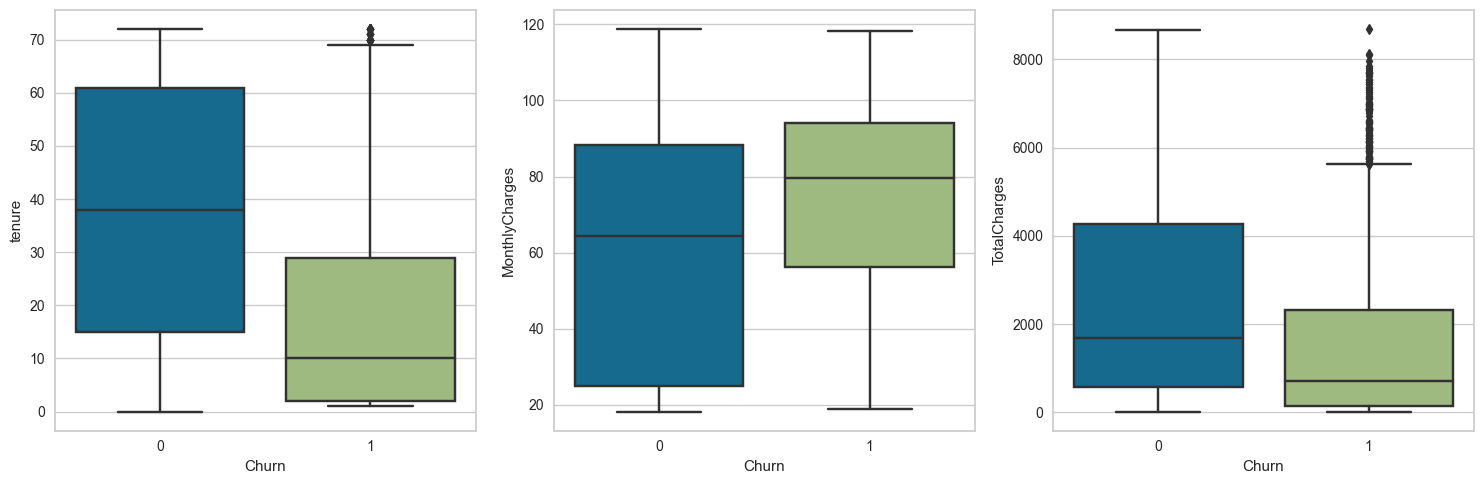

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))

for i, feature in enumerate(numeric_features):
    sns.boxplot(y = feature, x = 'Churn', data = df, ax = axs[i])
fig.tight_layout()

plt.show()

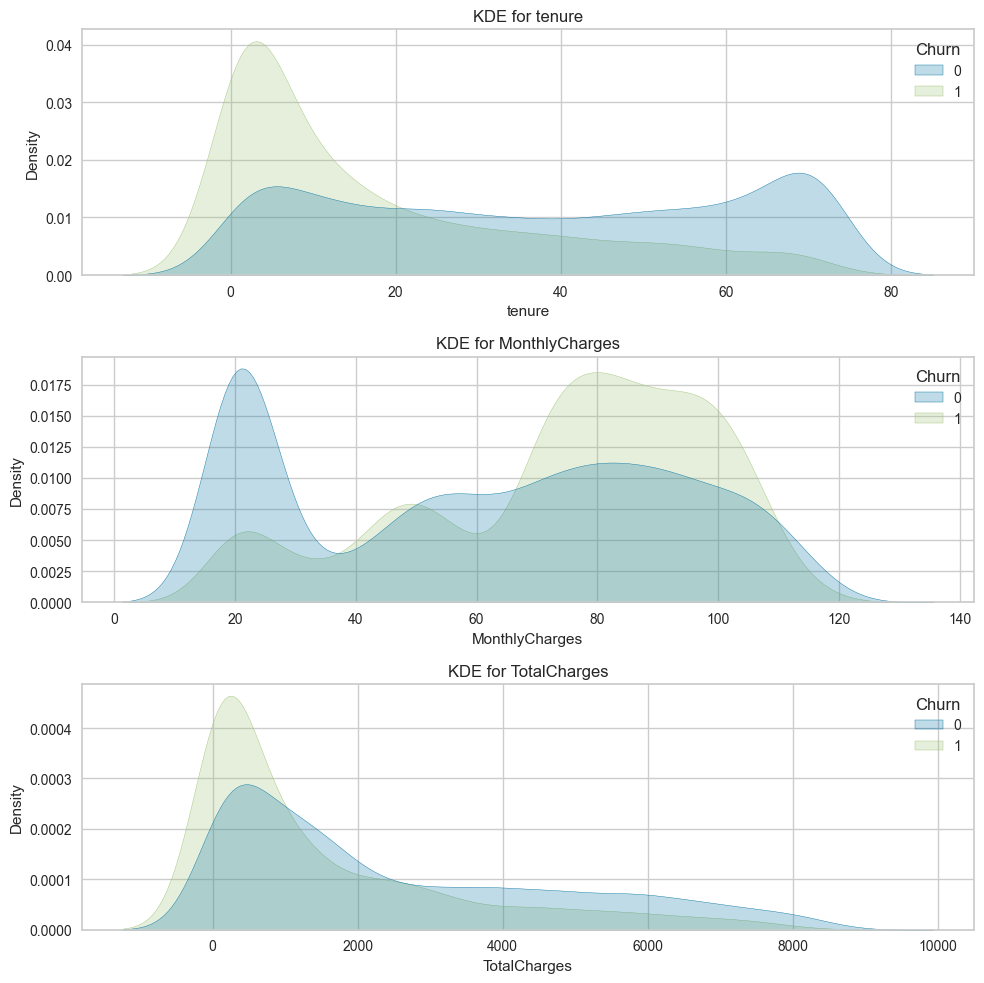

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

for i, feature in enumerate(numeric_features):
    sns.kdeplot(x=feature, hue='Churn', data=df, ax=axs[i], fill=True, common_norm=False, shade = True)
    axs[i].set_title(f'KDE for {feature}')

fig.tight_layout()
plt.show()

Two graphs were created for each categorical feature. 

The first shows the counts of each category based on Churn/Non-Churn, while the second shows the percentage of Churning customers in each category.

2) Demographic categorical features (gender, SeniorCitizen, Partner, Dependants)

- There is a small number of Senior Citizens in our data, however, among them there is a higher percentage of Churners than in the non-Senior category.
- There is a higher percentage of Churners among customers without a partner and without dependants

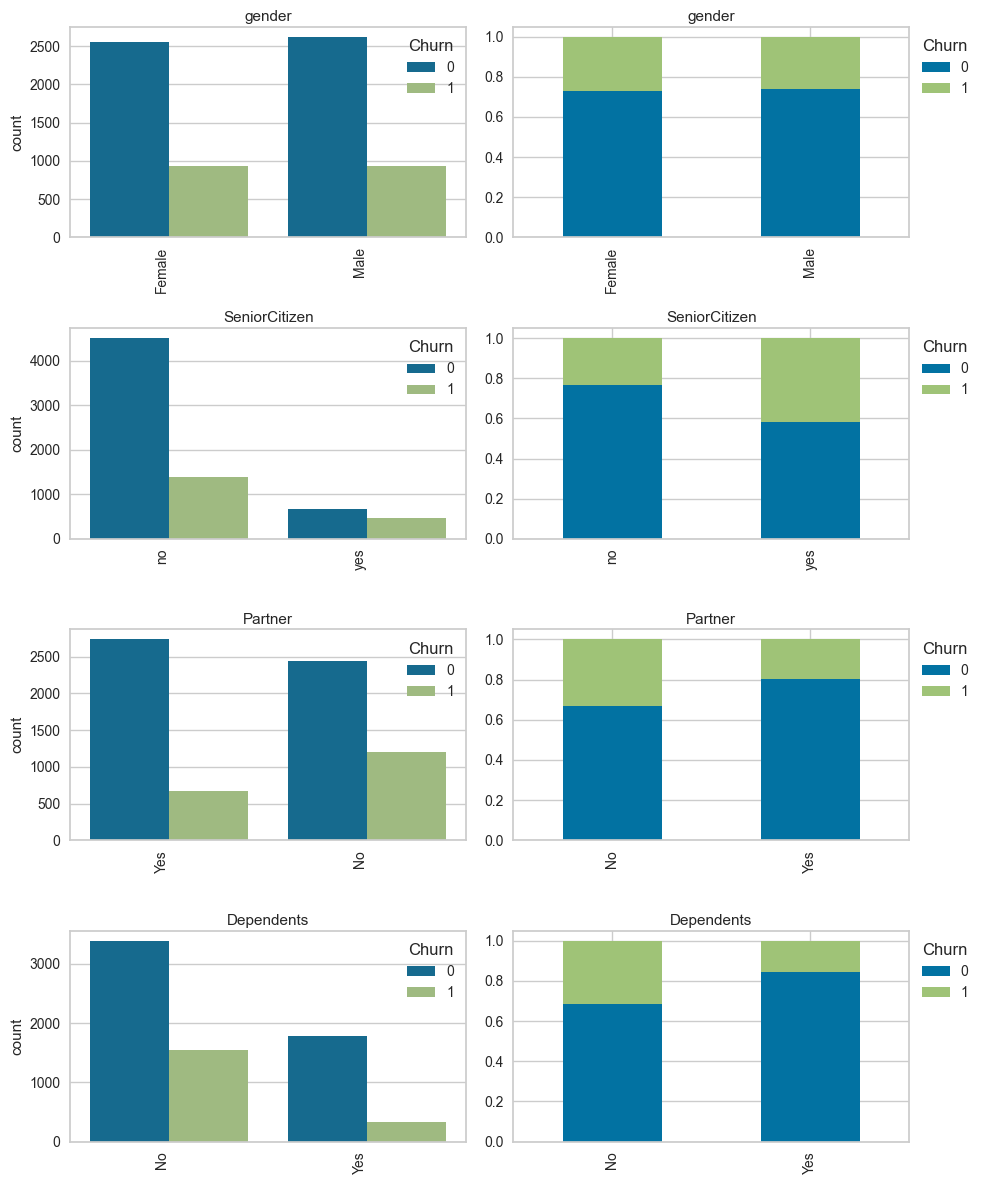

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 12))

axs = axs.flatten()

for i, feature in enumerate(demographic_cat_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axs[i * 2])
    axs[i * 2].set_xticklabels(axs[i * 2].get_xticklabels(), rotation=90, horizontalalignment='right')
    axs[i * 2].set_xlabel(feature)
    axs[i * 2].xaxis.set_label_position('top')
    
    counts = df.groupby([feature, 'Churn']).size().unstack()
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    ax = proportions.plot(kind='bar', stacked=True, ax=axs[i * 2 + 1])
    ax.set_xlabel(feature)
    axs[i * 2 + 1].xaxis.set_label_position('top')
    
    ax.legend(title='Churn', bbox_to_anchor=(1, 1), loc='upper left')

fig.tight_layout()
plt.show()

3) Service categorical features (PhoneService, InternetService, Partner, MultipleLines)

- Despite the fact that there are large differences in the number of customers in the groups relating to Phone Service and Multiple Lines, there are no large percentage differences in the number of Churning customers between the groups for those two variables
- There is a significantly higher percentage of Churners in the group of people with fiber optic as internet service than those with DSL and those without

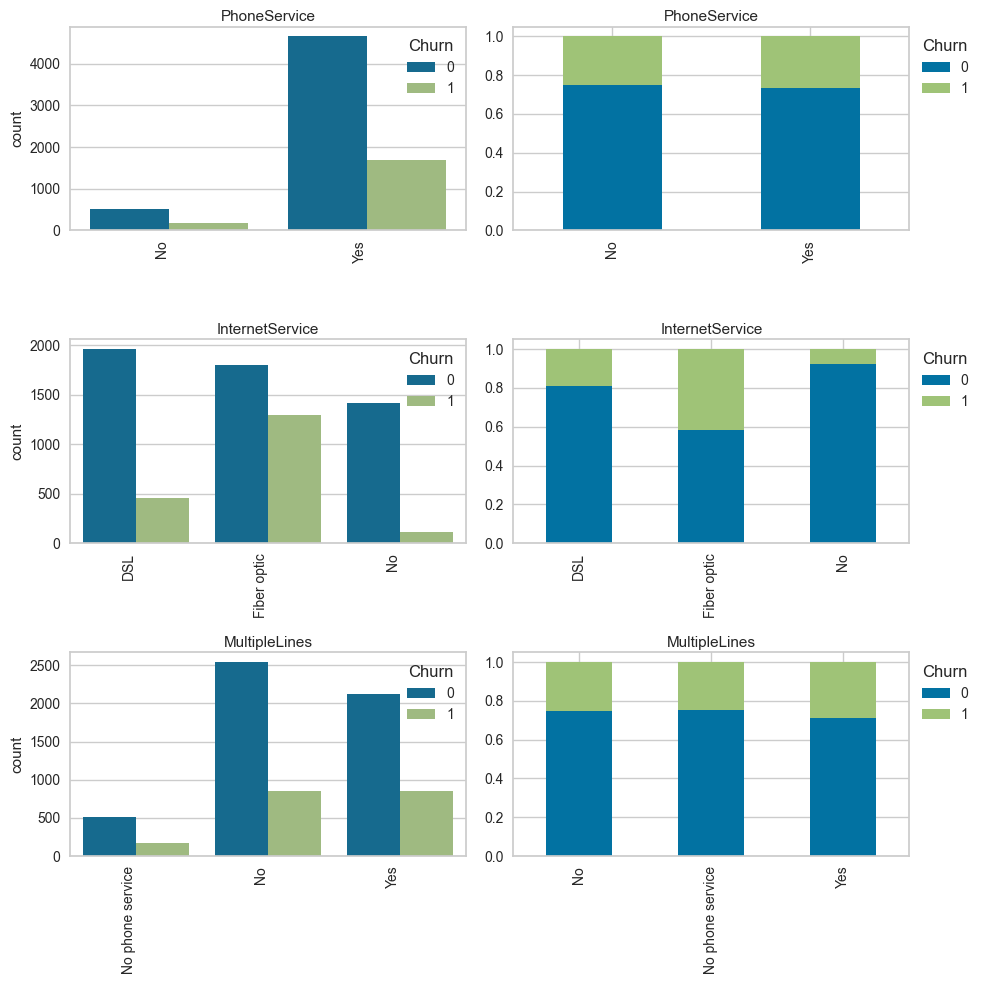

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

axs = axs.flatten()

for i, feature in enumerate(service_cat_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axs[i * 2])
    axs[i * 2].set_xticklabels(axs[i * 2].get_xticklabels(), rotation=90, horizontalalignment='right')
    axs[i * 2].set_xlabel(feature)
    axs[i * 2].xaxis.set_label_position('top')
    
    counts = df.groupby([feature, 'Churn']).size().unstack()
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    ax = proportions.plot(kind='bar', stacked=True, ax=axs[i * 2 + 1])
    ax.set_xlabel(feature)
    axs[i * 2 + 1].xaxis.set_label_position('top')
    
    ax.legend(title='Churn', bbox_to_anchor=(1, 1), loc='upper left')

fig.tight_layout()
plt.show()

4) Streaming categorical features (StreamingTV, StreamingMovies)

- Graphs for both of the features show that there is lower percentage of Churners for those having no internet service.
- For customers that have or dont have the Streaming TV/Streaming Movies there are very low differences in the percentage od Churners

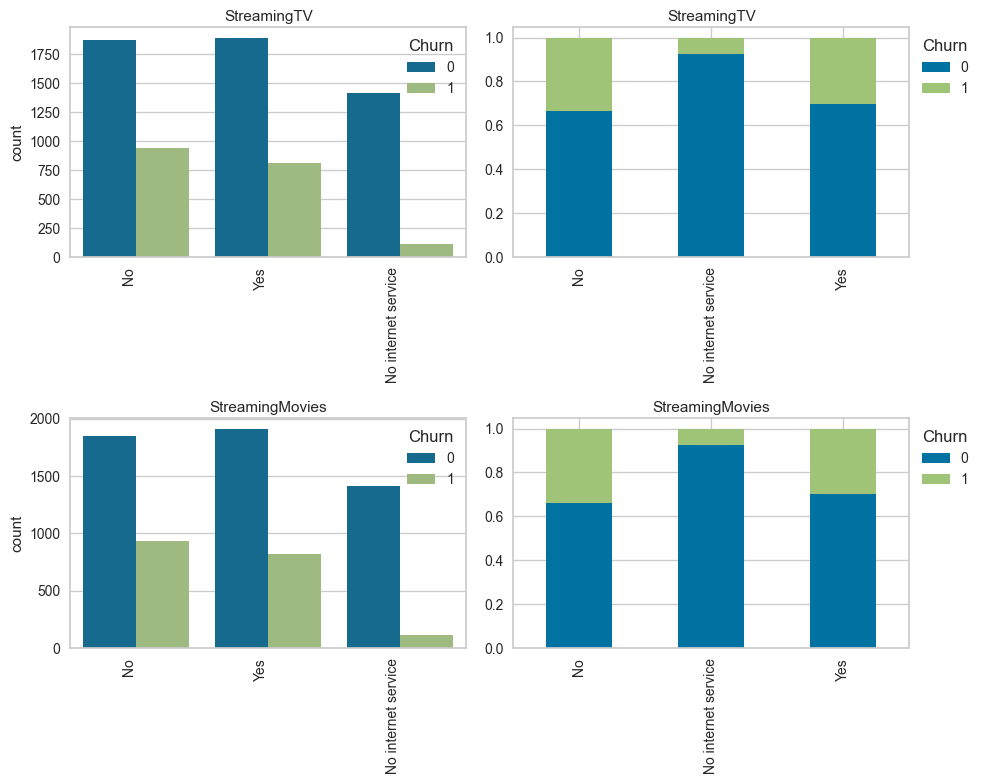

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axs = axs.flatten()

for i, feature in enumerate(streaming_cat_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axs[i * 2])
    axs[i * 2].set_xticklabels(axs[i * 2].get_xticklabels(), rotation=90, horizontalalignment='right')
    axs[i * 2].set_xlabel(feature)
    axs[i * 2].xaxis.set_label_position('top')
    
    counts = df.groupby([feature, 'Churn']).size().unstack()
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    ax = proportions.plot(kind='bar', stacked=True, ax=axs[i * 2 + 1])
    ax.set_xlabel(feature)
    axs[i * 2 + 1].xaxis.set_label_position('top')
    
    ax.legend(title='Churn', bbox_to_anchor=(1, 1), loc='upper left')

fig.tight_layout()
plt.show()

5) Tech categorical features (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport)

- Graphs for all of the tech features show that there is lower percentage of Churners for those having no internet service.
- For all of the tech features there is a higher percentage of Churning customers for groups that dont have additional service

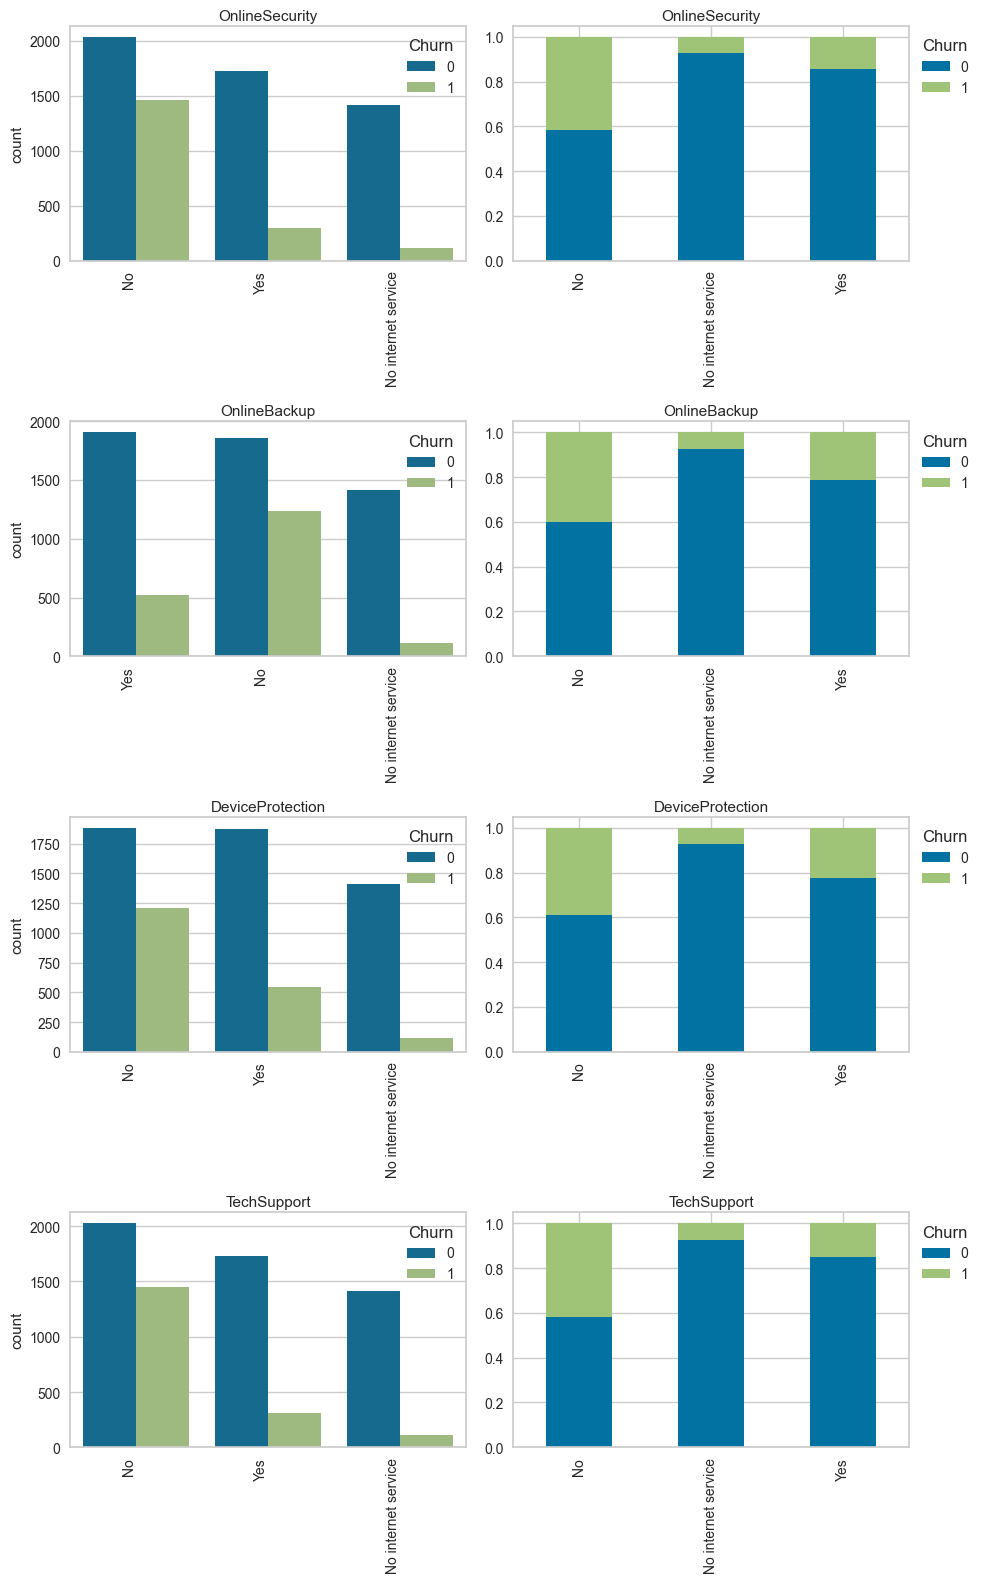

In [16]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 16))

axs = axs.flatten()

for i, feature in enumerate(tech_cat_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axs[i * 2])
    axs[i * 2].set_xticklabels(axs[i * 2].get_xticklabels(), rotation=90, horizontalalignment='right')
    axs[i * 2].set_xlabel(feature)
    axs[i * 2].xaxis.set_label_position('top')
    
    counts = df.groupby([feature, 'Churn']).size().unstack()
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    ax = proportions.plot(kind='bar', stacked=True, ax=axs[i * 2 + 1])
    ax.set_xlabel(feature)
    axs[i * 2 + 1].xaxis.set_label_position('top')
    
    ax.legend(title='Churn', bbox_to_anchor=(1, 1), loc='upper left')

fig.tight_layout()
plt.show()

6) Payment categorical features (Contract, PaperlessBilling, PaymentMethod)

- There is a significantly higher percentage of Churners in the group of customers with a month-to-month type of contract
- There is a higer percentage of Churners in the group of customers who have chosen paperless billing
- There is a significantly higher percentage of Churners in the group of customers using electronic check payment method than in the groups using another payment methods

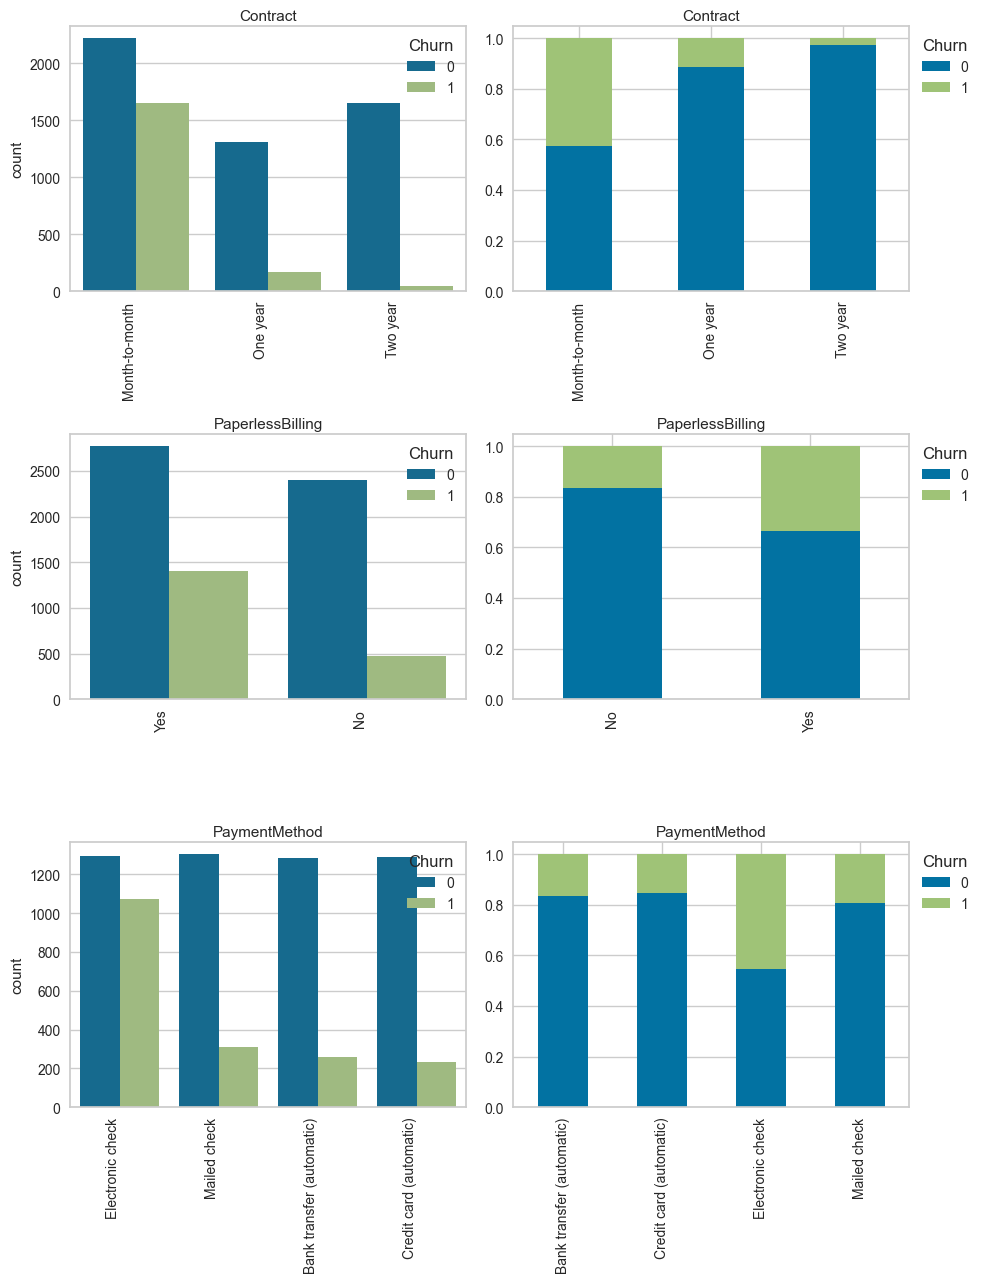

In [17]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 13))

axs = axs.flatten()

for i, feature in enumerate(payment_cat_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axs[i * 2])
    axs[i * 2].set_xticklabels(axs[i * 2].get_xticklabels(), rotation=90, horizontalalignment='right')
    axs[i * 2].set_xlabel(feature)
    axs[i * 2].xaxis.set_label_position('top')
    
    counts = df.groupby([feature, 'Churn']).size().unstack()
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    ax = proportions.plot(kind='bar', stacked=True, ax=axs[i * 2 + 1])
    ax.set_xlabel(feature)
    axs[i * 2 + 1].xaxis.set_label_position('top')
    
    ax.legend(title='Churn', bbox_to_anchor=(1, 1), loc='upper left')

fig.tight_layout()
plt.show()

# Feature engineering and feature selection

I decided to use standardization of numerical variables to make the model independent of differences in value scales

In [18]:
df[numeric_features] = df[numeric_features].apply(lambda x: (x-x.mean())/x.std())

Since categorical variables have two to four values and no natural hierarchy I decided to use one hot encoding

In [19]:
df_encoded = pd.get_dummies(df[categorical_features], columns=categorical_features, drop_first=True, prefix = categorical_features)

In [20]:
df = pd.concat([df, df_encoded], axis = 1)
df.drop(columns=categorical_features, axis =1, inplace= True)

Creation of the correlation heatmap

<Axes: >

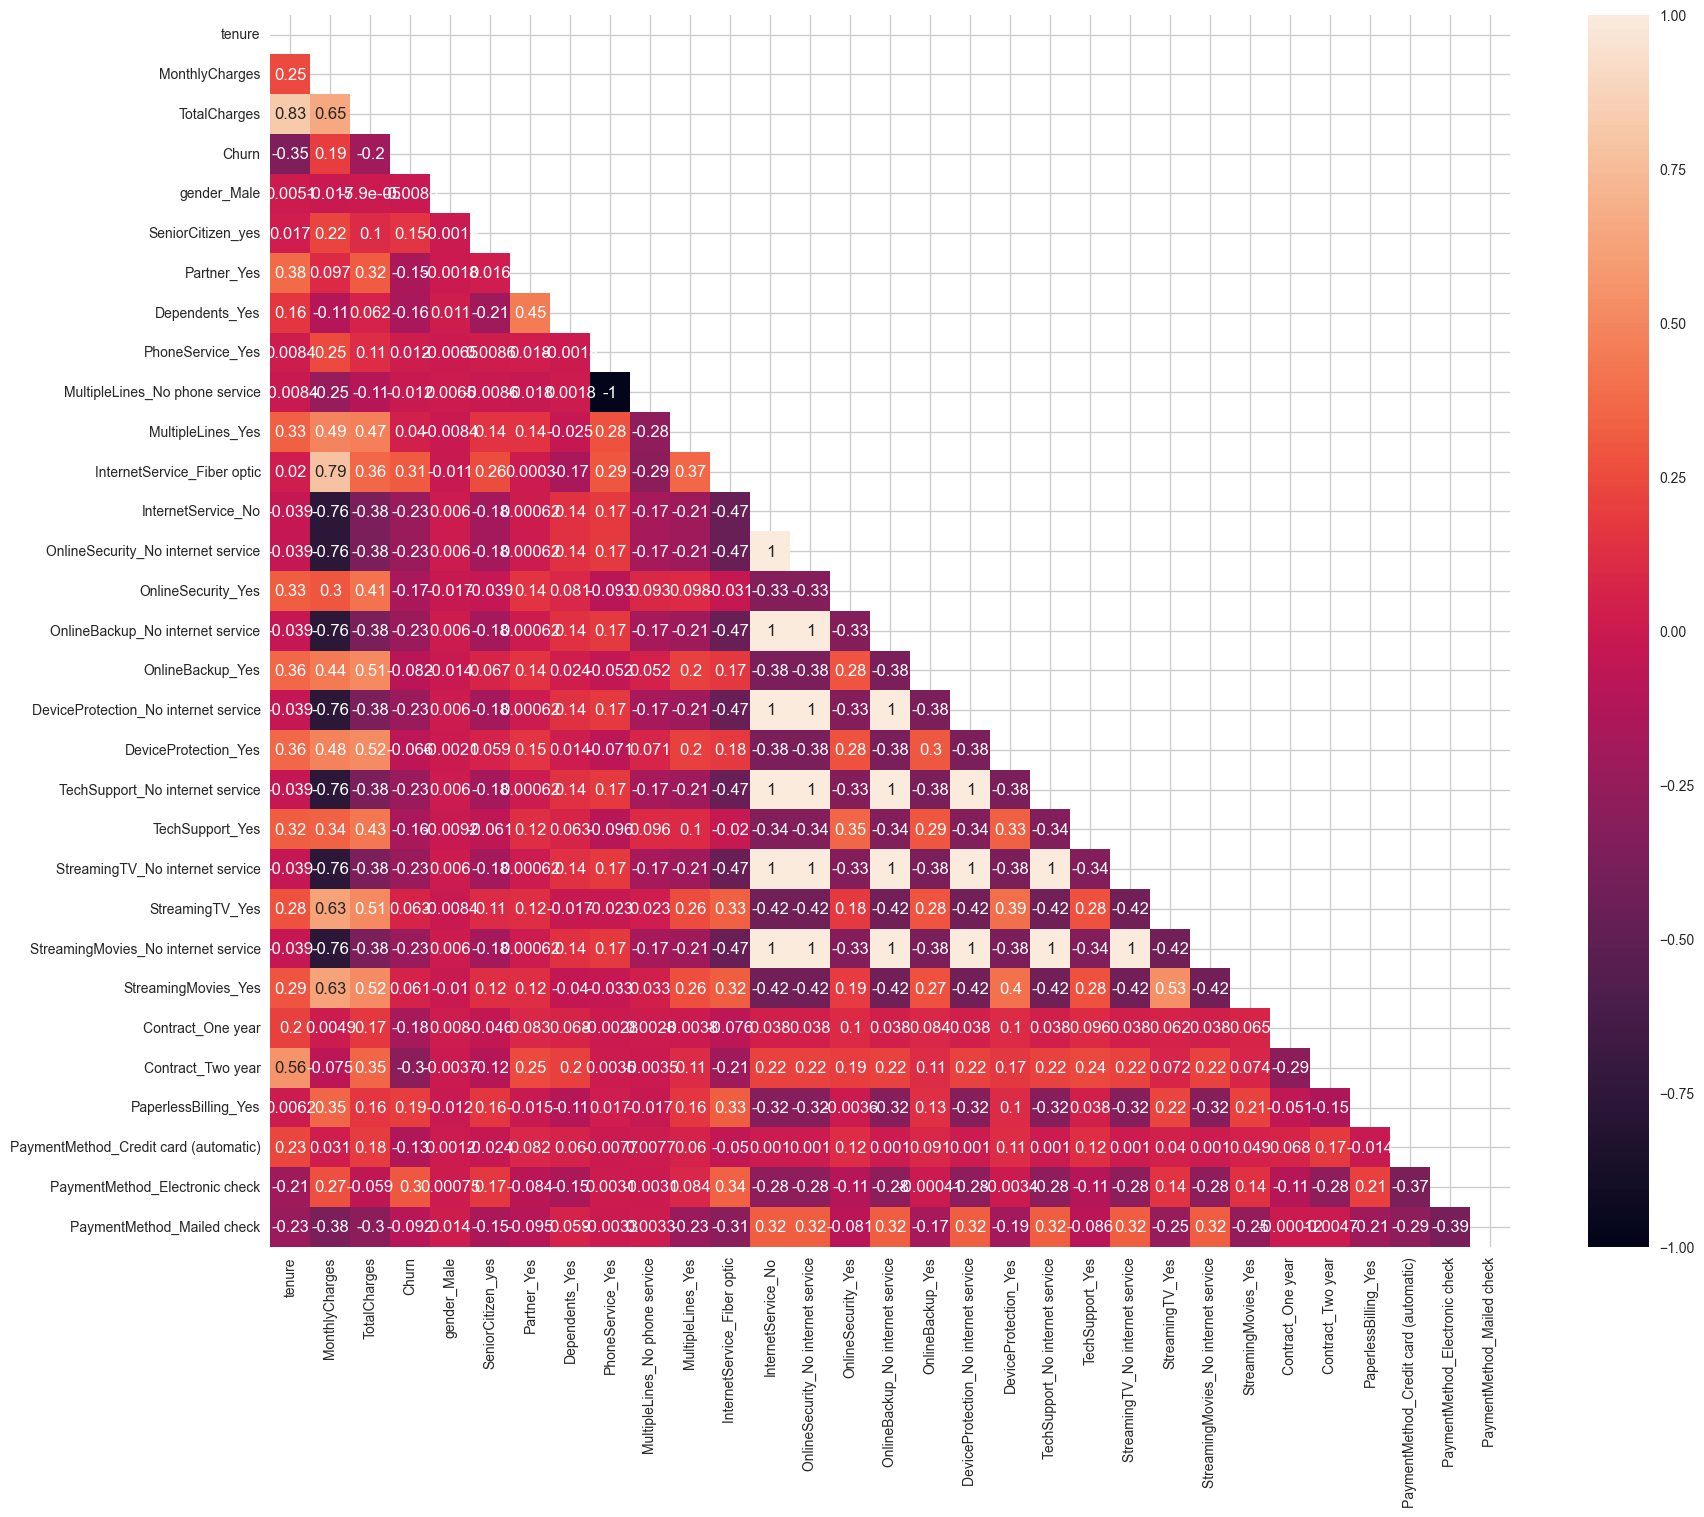

In [21]:
mask = np.triu(np.ones_like(df.corr()))
plt.figure(figsize=(20,16))
sns.heatmap(df.corr(), fmt = '.2g', annot = True, mask = mask)

There are 7 festures that indicate a lack of Internet service. 
This leads to a high correlation between them, therefore, I decided to leave only one

In [22]:
no_internet_features = ['OnlineSecurity_No internet service', 
                        'OnlineBackup_No internet service', 
                        'DeviceProtection_No internet service', 
                        'TechSupport_No internet service', 
                        'StreamingTV_No internet service', 
                        'StreamingMovies_No internet service',]
df.drop(columns= no_internet_features, axis = 1, inplace = True)


Selecting variables based on Mutual Information scores


In [23]:
y = df['Churn']
df.drop(columns = 'Churn', axis= 1, inplace = True)
X = df

In [24]:
MI = mutual_info_classif(X, y)

In [25]:
mi_scores_sorted = sorted(list(zip(X.columns, MI)), key=lambda x: x[1], reverse=True)

for feature, mi_score in mi_scores_sorted:
    print(f"MI for {feature}: {mi_score}")

MI for tenure: 0.07670057393770358
MI for Contract_Two year: 0.0627961369690988
MI for InternetService_Fiber optic: 0.05002865577245563
MI for MonthlyCharges: 0.04532098043689836
MI for TotalCharges: 0.04343714396772147
MI for PaymentMethod_Electronic check: 0.03895796578377153
MI for InternetService_No: 0.0299920300527472
MI for Dependents_Yes: 0.02648727018446051
MI for OnlineSecurity_Yes: 0.02636853732644462
MI for PaperlessBilling_Yes: 0.02217649910460695
MI for Partner_Yes: 0.016518931706646534
MI for Contract_One year: 0.011642644818447678
MI for SeniorCitizen_yes: 0.011387010020698751
MI for PaymentMethod_Credit card (automatic): 0.009856921524059148
MI for StreamingMovies_Yes: 0.009697706733380107
MI for TechSupport_Yes: 0.008558625240640438
MI for PaymentMethod_Mailed check: 0.006289929369726721
MI for StreamingTV_Yes: 0.006055815156458033
MI for DeviceProtection_Yes: 0.0044964207931297295
MI for gender_Male: 0.0027734759097899353
MI for OnlineBackup_Yes: 0.0020782387192497254

In [26]:
feature, mi_value = zip(*mi_scores_sorted)

Creating a graph on MI scores for each variable

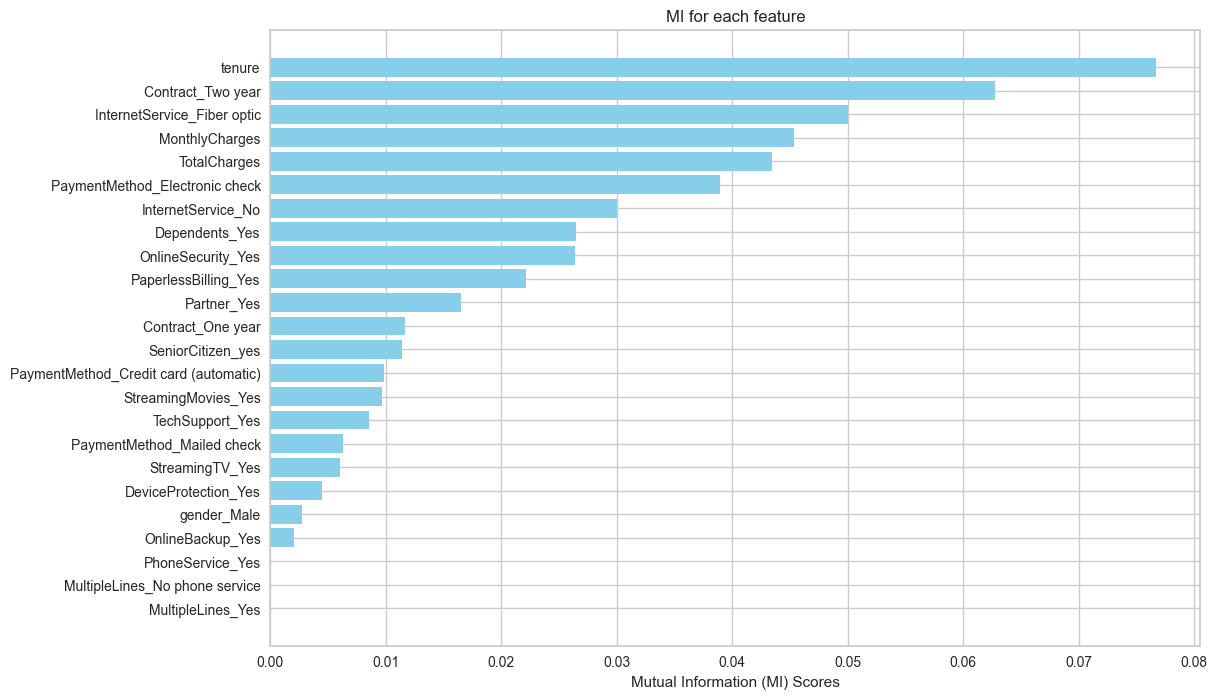

In [27]:
plt.figure(figsize=(12, 8))
plt.barh(feature, mi_value, color='skyblue')
plt.xlabel('Mutual Information (MI) Scores')
plt.title('MI for each feature')
plt.gca().invert_yaxis()  
plt.show()

I choose variables that have MI score above 0.01

In [28]:
selected_cols = []
treshold = 0.01
for col, mi_score in mi_scores_sorted:
    if mi_score > treshold:
        selected_cols.append(col)
X = df[selected_cols]

# Model Selection and Evaluation

Dividing the dataset into training and testing in 70/30 ratio, with stratify option that ensure the split maintains the same class distribution in bith datasets as the original dataset.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.3, random_state=1997)

In [30]:
s = setup(data = X_train, target = y_train, session_id=123, preprocess=False)

Model and probability threshold selection using PyCaret library

Model will be choosed from the list:
 - Decision Tree
 - Extra Tree
 - Random Forest
 - Ada Boost
 - CatBoost
 - Light Gradient Boosting Machine
 - Gradient Boosting
 - Extreme Gradient Boosting

In [31]:
selected_models = ['dt', 'et', 'rf', 'ada', 'catboost', 'lightgbm', 'gbc', 'xgboost']

In [32]:
best_model1 = compare_models(fold = 5, include = selected_models, probability_threshold = 0.4)

Processing:   0%|          | 0/37 [00:00<?, ?it/s]

In [33]:
best_model2 = compare_models(fold = 5, include = selected_models, probability_threshold = 0.5)

Processing:   0%|          | 0/37 [00:00<?, ?it/s]

In [34]:
best_model3 = compare_models(fold = 5, include = selected_models, probability_threshold = 0.6)

Processing:   0%|          | 0/37 [00:00<?, ?it/s]

- With the increase of probability threshold there is a significant decrease in recall of the models -  it means that our models do worse job finding actual Churners
- As there is no increase in accuracy or the AUC score with increasing the probability threshold it will be set as 0.4

- I choose the Gradient Boosting Classifier as the final model

Finding best hyperparameters for model using hyperopt library

- Setting the hyperparameters space

In [35]:
gbc_param_space = {
    'n_estimators': hp.choice('n_estimators', range(50, 201, 50)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(1, 11)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

- Setting the objective function with the main metric as a recall, because we want to have a well-performing model that can correctly classify most real Churners

In [36]:
def gb_hyperopt(params):
    model = GradientBoostingClassifier(**params)
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall',).mean()
    return {'loss': -recall, 'status': STATUS_OK}

In [37]:
best_gb_params = fmin(fn = gb_hyperopt, space = gbc_param_space, algo = tpe.suggest, max_evals = 100, return_argmin=False)

100%|█████████████████████████████████████████████| 100/100 [01:53<00:00,  1.13s/trial, best loss: -0.5549910795238514]


- Fitting model with the best parameters on traning data
- Applying trained model on test dataset and setting the probability treshold as 0.4

In [38]:
best_gb = GradientBoostingClassifier(**best_gb_params)
best_gb.fit(X_train, y_train)
y_proba = best_gb.predict_proba(X_test)
threshold = 0.4
y_pred = (y_proba[:,1] > threshold).astype(int)

Evaluating model performance with Accuracy, AUC and Recall score

In [39]:
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba[:, 1])
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'AUC: {auc}')
print(f'Recall: {recall}')

Accuracy: 0.7879791765262659
AUC: 0.839033528125402
Recall: 0.6524064171122995


Conclusion from the metrics:
- Model accurately predicted target variable for approximately 78% of the samples in the test set
- Model has good ability to discriminate between two classes
- Model is able to detect 65% of all actual positive cases in the test set 